In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy import stats
import zipfile
#filtering reshape warnings deprecation
warnings.filterwarnings('ignore')


In [47]:
with zipfile.ZipFile("titanic.zip") as f:
    f.extractall()

In [48]:
#importing data and checking different variables and their types
data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
data.columns
len(data['Ticket'].unique())

#Dropping id and not useful varibles
data.drop(['PassengerId','Name','Ticket'],axis=1,inplace=True)
test.drop(['PassengerId','Name','Ticket'],axis=1,inplace=True)
data.describe(include='all')
data.isnull().sum()
trainy =data['Survived']
data = data.drop(['Survived'],axis=1)
data['Pclass']= pd.Categorical(data['Pclass'])
test['Pclass']= pd.Categorical(test['Pclass'])

In [49]:
data.isnull().sum() 
data[data['Age'].isnull()].index
data['Age']=data['Age'].fillna(data['Age'].mean())
test['Age']=test['Age'].fillna(data['Age'].mean())
trainy.groupby(data['Cabin']).count().head()

Cabin
A10    1
A14    1
A16    1
A19    1
A20    1
Name: Survived, dtype: int64

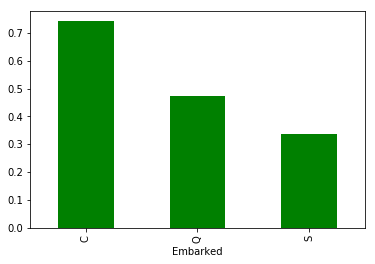

In [50]:
#Extracting character cabin from string
index=pd.Series(data['Cabin'].dropna()).str.slice(0,1).index
data['Cabin'][index]=pd.Series(data['Cabin'].dropna()).str.slice(0,1)

index=pd.Series(test['Cabin'].dropna()).str.slice(0,1).index
test['Cabin'][index]=pd.Series(test['Cabin'].dropna()).str.slice(0,1)

#nan behaves differently, more in number, making it a separate class
trainy.groupby(data['Cabin'].fillna('dummy')).mean()

#Visualization
trainy.groupby(data['Sex']).mean().plot(kind='bar',color='green')
trainy.groupby(data['Pclass']).mean().plot(kind='bar',color='green')
trainy.groupby(data['Embarked']).mean().plot(kind='bar',color='green')


In [51]:
#Removing sparse categories
data['Cabin']=data['Cabin'].replace(['T'],['A'])

In [52]:
#converting to one hot encoding of data
data =pd.get_dummies(data,dummy_na=False,drop_first=True)
test =pd.get_dummies(test,dummy_na=False,drop_first=True)


In [53]:
#splitting data for train test validation
from sklearn.model_selection import train_test_split
trainx, testx, trainy, testy = train_test_split(data, trainy, test_size=0.3, random_state=42)

#Data columns are at different scale, import to normalize before appling gradient descent optim 
def normalize_and_stackintercept(trainx,testx):
    traindatax=trainx
    testdatax=testx
    mu= traindatax.mean(axis=0)
    sigma= traindatax.std(axis=0)
    traindatax= (traindatax-mu)/sigma
    traindatax = np.array(traindatax)    
    traindatax=np.hstack([np.ones((traindatax.shape[0],1)),traindatax])
    testdatax = (testdatax-mu)/sigma
    testdatax = np.array(testdatax)    
    testdatax=np.hstack([np.ones((testdatax.shape[0],1)),testdatax])    
    return traindatax,testdatax

In [54]:
#Data columns are at different scale, import to normalize before appling gradient descent optim
#stacking 1 for intercept term
trainx,testx= normalize_and_stackintercept(trainx,testx)
    
def sigmoid(x):
    prob=1.0/(1+np.exp(-x))
    return prob

In [55]:
#Running loops for gradient descent optimization
    
def Gradient_Descent(trainx,trainy,testx,testy,lr=0.05,iters=100):
    train_m = trainx.shape[0]
    test_m = testx.shape[0]
    trainy=trainy.reshape(train_m,1)
    testy=testy.reshape(test_m,1)
    n = trainx.shape[1]
    coeff= np.zeros((n,1))
    train_Loss=[]
    test_Loss=[]

    for iterations in range(iters):
        train_prediction= sigmoid(trainx.dot(coeff))
        test_prediction= sigmoid(testx.dot(coeff))
        train_loss= -np.sum(trainy*np.log(train_prediction)+(1-trainy)*np.log(1-train_prediction))/train_m 
        test_loss=  -np.sum(testy*np.log(test_prediction)+(1-testy)*np.log(1-test_prediction))/test_m 
        print("iteration "+str(iterations)+"train_loss: "+str(train_loss) +" test_loss: "+str(test_loss))
        train_Loss.append(train_loss)
        test_Loss.append(test_loss) 
        gradient=(trainx.T).dot(train_prediction-trainy)/train_m
        coeff= coeff-lr*(gradient)
    Loss_dict=pd.DataFrame({'train_Loss':train_Loss,'test_Loss':test_Loss})   
    return coeff,Loss_dict

iteration 0train_loss: 0.6931471805599454 test_loss: 0.6931471805599453
iteration 1train_loss: 0.6856026094181301 test_loss: 0.6855731289907518
iteration 2train_loss: 0.678349532635492 test_loss: 0.6783073760581364
iteration 3train_loss: 0.6713751698895234 test_loss: 0.6713360930395187
iteration 4train_loss: 0.664667203002512 test_loss: 0.6646459470192878
iteration 5train_loss: 0.6582137838135371 test_loss: 0.6582241119226983
iteration 6train_loss: 0.6520035372280184 test_loss: 0.6520582739474637
iteration 7train_loss: 0.6460255601224087 test_loss: 0.6461366321403018
iteration 8train_loss: 0.6402694167469588 test_loss: 0.6404478948368094
iteration 9train_loss: 0.6347251312233464 test_loss: 0.6349812726391036
iteration 10train_loss: 0.6293831776808037 test_loss: 0.6297264685517996
iteration 11train_loss: 0.6242344685178158 test_loss: 0.6246736658373772
iteration 12train_loss: 0.619270341219347 test_loss: 0.6198135140903277
iteration 13train_loss: 0.614482544103986 test_loss: 0.615137113

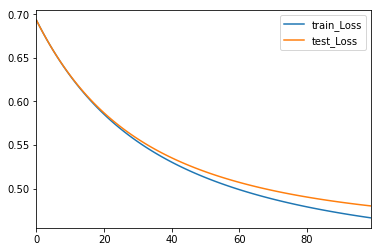

In [56]:
coeff,loss_dict = Gradient_Descent(trainx,trainy.values,testx,testy.values,lr=0.05,iters=100)
loss_dict.plot()


#setting cutoff for class prediction from probability values
cutoff=np.mean(trainy)


In [57]:
def predict_proba(data,coeff):
    return sigmoid(data.dot(coeff))

def predict(data,coeff,cutoff):
    return (sigmoid(data.dot(coeff))>cutoff)*1.0
    

In [58]:
train_prediction= predict(trainx,coeff,cutoff)
test_prediction=  predict(testx,coeff,cutoff)

def accuracy(datay,prediction):
    m= datay.shape[0]
    return np.mean(datay.reshape(m,)==prediction.reshape(m,))

In [59]:
train_accuracy= accuracy(trainy.values,train_prediction)
test_accuracy= accuracy(testy.values,test_prediction)

def confusion_matrix(datay,prediction):
    m=datay.shape[0]
    confmat=pd.crosstab(datay.reshape(m,),prediction.reshape(m,))
    return confmat

In [60]:
confmat=confusion_matrix(testy.values,test_prediction)
confmat
#Finding specificty and sensitivity of model at specified cutoff

col_0,0.0,1.0
row_0,,
0,115,42
1,22,89


In [61]:
def metric(confmat):
    confmat=confmat.values
    specificity=confmat[0,0]/np.sum(confmat[0,:])
    sensitivity=confmat[1,1]/np.sum(confmat[1,:])
    return sensitivity,specificity

sens,spec=metric(confmat)

In [62]:
#Plotting Roc curves and attempting to find auc value

def plot_roccurve(data,datay,coeff,num_points=1000):
    Sensitivity=[]
    Specificity=[]
    p = np.linspace(0.15,0.9,num_points)
    for index in np.arange(len(p)):
        data_prediction=predict(data,coeff,p[index])
        confmat= confusion_matrix(datay,data_prediction)
        sens,spec=metric(confmat)
        Sensitivity.append(sens)
        Specificity.append(spec)
    #ROC Curves
    plt.scatter(1-np.array(Specificity),np.array(Sensitivity))
    x= np.linspace(0,1,50)
    plt.plot(x,x, linestyle='solid',color='red')
    plt.xlabel('1-Specificity') 
    plt.ylabel('Sensitivity') 
    plt.title('ROC_CURVE')      
    return np.array(Specificity),np.array(Sensitivity)

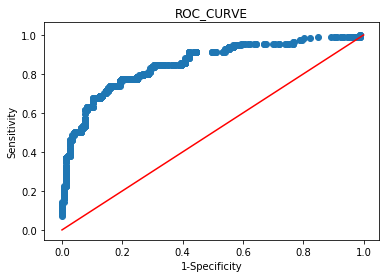

In [63]:
Sens,Spec= plot_roccurve(testx,testy.values,coeff,num_points=1000)

In [64]:
#Newton's method yields same solution in 5 iterations 
LossNewton=[]
def NewtonOptim(trainx,trainy,iters=10):
    n = trainx.shape[1]
    coeff= np.zeros((n,1))
    m=trainx.shape[0]
    trainy=trainy.reshape(m,1)
    for iterations in range(10):
        prediction= sigmoid(trainx.dot(coeff))
        loss= -np.sum(trainy*np.log(prediction)+(1-trainy)*np.log(1-prediction))/m
        vartrainy = prediction*(1-prediction).reshape(m,1)
        vartrainy = np.eye(m)*vartrainy
        hess = -(trainx.T).dot(vartrainy.dot(trainx))
        coeff = coeff-np.linalg.inv(hess).dot((trainx.T).dot(trainy-prediction))
        LossNewton.append(loss)
        print(loss)
    return coeff,LossNewton,hess

In [65]:
NewCoeff,NewtonLoss,hess=NewtonOptim(trainx,trainy.values,iters=10)  

0.6931471805599454
0.44631037910018445
0.4279026153391865
0.42688057342834207
0.4268742767717537
0.42687427615113305
0.42687427615113305
0.42687427615113305
0.42687427615113305
0.42687427615113305


In [66]:
def compute_pvalue(trainx,coeff,hess):
    m=trainx.shape[0]
    n=trainx.shape[1]
    tstatistic= coeff/np.sqrt(np.diag(np.linalg.inv(-hess))).reshape(n,1)
    df=m-n
    pvalue = [2*(1-stats.t.cdf(tstat,df)) if tstat>0 else 2*stats.t.cdf(tstat,df) for tstat in tstatistic]
    return pvalue

In [67]:
pvalue=compute_pvalue(trainx,NewCoeff,hess)

#important features
(pd.Series(pvalue) < 0.05)[1:]

1      True
2      True
3     False
4     False
5     False
6     False
7      True
8      True
9     False
10     True
11     True
12    False
13    False
14    False
15     True
dtype: bool

In [68]:
important_features=data.columns[(pd.Series(pvalue) < 0.05)[1:]]
print(important_features)

Index(['Age', 'SibSp', 'Sex_male', 'Cabin_B', 'Cabin_D', 'Cabin_E',
       'Embarked_S'],
      dtype='object')
